In [1]:
# Installing packages
!pip install chart_studio
!pip install pyspark

     |████████████████████████████████| 71kB 3.7MB/s 
     |████████████████████████████████| 204.2MB 61kB/s 
     |████████████████████████████████| 204kB 45.9MB/s 
  Created wheel for pyspark: filename=pyspark-3.0.1-py2.py3-none-any.whl size=204612243 sha256=25d1f4cc8e336e1d219afd5b67abd35217bdf29596a46e62108344b776aebbf9
  Stored in directory: /root/.cache/pip/wheels/5e/bd/07/031766ca628adec8435bb40f0bd83bb676ce65ff4007f8e73f
Successfully built pyspark


In [81]:
# Spark session
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.types import (StructField,StructType,StringType,IntegerType,FloatType,LongType,DateType)

spark = SparkSession.builder.master('local[*]').appName("Zomato").config("spark.some.config.option","kf").enableHiveSupport().config("spark.executor.memory","48g").config("spark.driver.memory", "48g").getOrCreate()
spark.conf.set("spark.executor.memory_overhead", "32g")

In [82]:
# Importing libraries
import chart_studio.plotly as py
import plotly.graph_objs as go
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

import time
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd 
from geopy.geocoders import Nominatim
import folium
from folium.plugins import HeatMap

import cufflinks as cf
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
cf.go_offline()

init_notebook_mode(connected=True)
import os

In [83]:
# Creating data schema
data_schema = [  
               StructField('address',StringType(),True),
               StructField('name',StringType(),True),
               StructField('onlineOrder',StringType(),True),
               StructField('bookTable',StringType(),True),
               StructField('ratingsBy5',StringType(),True),  
               StructField('votes',IntegerType(),True),
               StructField('phone',StringType(),True),
               StructField('location',StringType(),True),
               StructField('restType',StringType(),True),
               StructField('dishLiked',StringType(),True),
               StructField('cuisines',StringType(),True),
               StructField('approx_cost(for two people)',StringType(),True),
               StructField('reviewsList',StringType(),True),
               StructField('listedInType',StringType(),True),
               StructField('listedInCity',StringType(),True),  
              ]
final_struc = StructType(fields=data_schema)

In [84]:
# connecting to g drive
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

os.chdir("/content/drive/My Drive")
!ls

Mounted at /content/drive
'Colab Notebooks'		      IMG_20200912_155057.jpg
'Diwali Syracuse'		      IMG_20200912_155142.jpg
 file1.csv			      IMG_20200912_155411.jpg
 GfG.csv			      IMG_20200912_155413.jpg
'How to get started with Drive.pdf'   IMG_20200912_155418.jpg
 IMG_20200912_145706.jpg	      IMG_20200912_155510.jpg
 IMG_20200912_145708.jpg	     'iSchool PUBG Tournament Poll.gform'
 IMG_20200912_145713.jpg	      NeelSamant-Upkey_Fall_VIP.mp4
 IMG_20200912_145716.jpg	     'Requirements email draft.docx'
 IMG_20200912_151333.jpg	      Saratoga
 IMG_20200912_155051.jpg	      Waterloo
 IMG_20200912_155054.jpg	      zomato.csv
 IMG_20200912_155055.jpg


In [85]:
# importing data
zomatopd = pd.read_csv('zomato.csv',sep=',')
start_mem_usg = zomatopd.memory_usage(deep=True,index=False).sum() / 1024**2 
print("Memory usage of properties dataframe is :",round(start_mem_usg,2)," MB")

Memory usage of properties dataframe is : 572.18  MB


In [86]:
# Dealing with missing values

for col in zomatopd.columns:
    count = zomatopd[col].isnull().sum()
    pct_missing=np.mean(zomatopd[col].isnull())
    print('Missing Values: {}  {}, {}%'.format(col,count,round(pct_missing*100,3)))

Missing Values: url  0, 0.0%
Missing Values: address  0, 0.0%
Missing Values: name  0, 0.0%
Missing Values: online_order  0, 0.0%
Missing Values: book_table  0, 0.0%
Missing Values: rate  7775, 15.034%
Missing Values: votes  0, 0.0%
Missing Values: phone  1208, 2.336%
Missing Values: location  21, 0.041%
Missing Values: rest_type  227, 0.439%
Missing Values: dish_liked  28078, 54.292%
Missing Values: cuisines  45, 0.087%
Missing Values: approx_cost(for two people)  346, 0.669%
Missing Values: reviews_list  0, 0.0%
Missing Values: menu_item  0, 0.0%
Missing Values: listed_in(type)  0, 0.0%
Missing Values: listed_in(city)  0, 0.0%


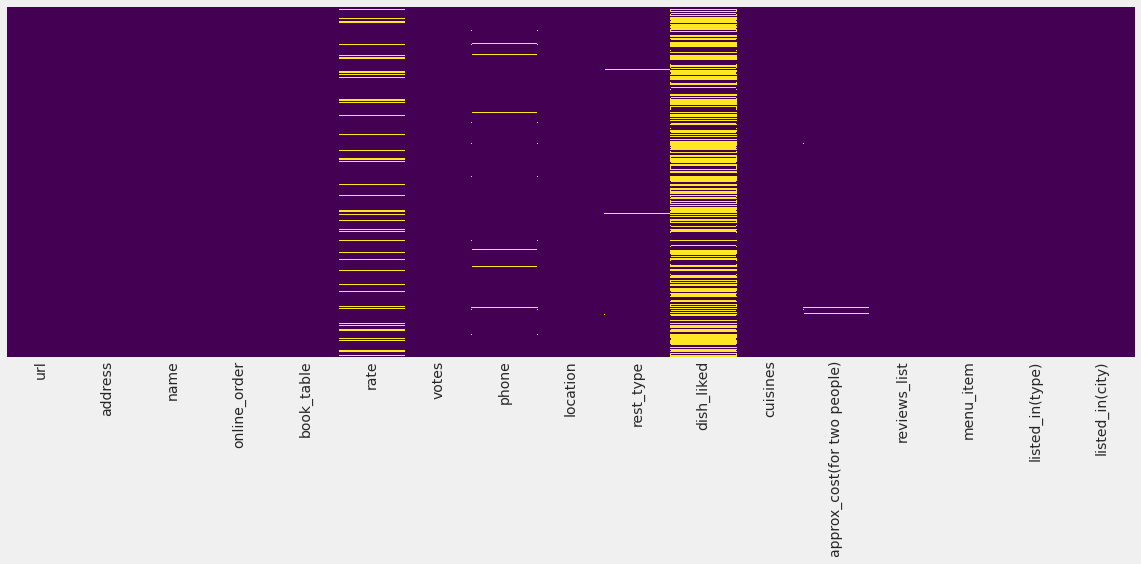

In [87]:
# plot of missing values
plt.figure(figsize=(18,6))
plt.style.use('fivethirtyeight')
sns.heatmap(zomatopd.isnull(),yticklabels=False, cbar=False, cmap= 'viridis');

In [88]:
# Dealing with Null values using interpolation

# url
zomatopd.drop(['url','menu_item'],axis=1,inplace=True)

# phone
zomatopd['phone'] = zomatopd['phone'].apply(lambda x:str(x).replace('+91','').replace(' ','').strip().split('\r\n')[0].strip() if '+91' or '080' in str(x) else str(x))
zomatopd['phone'] = zomatopd['phone'].replace({'nan':'Unknown'})
zomatopd['phone'] = zomatopd['phone'].apply(lambda x: '+91 ' + str(x) if (not str(x).startswith('0')) else str(x))

zomatospark = spark.createDataFrame(zomatopd,final_struc)

# vote
zomatopd['votes'] = pd.to_numeric(zomatopd['votes'])

# approx cost
zomatopd['approx_cost(for two people)'] = zomatopd['approx_cost(for two people)'].apply(lambda x:str(x).replace(',','') if ',' in str(x) else str(x))
zomatopd['approx_cost(for two people)'] = pd.to_numeric(zomatopd['approx_cost(for two people)'].replace({'nan':np.nan})).interpolate()
zomatopd['approx_cost(for two people)'] = zomatopd['approx_cost(for two people)'].apply(lambda x:np.round(x))

# ratingsBy5
zomatopd['ratingsBy5'] = zomatopd['rate'].apply(lambda x: str(x).split('/')[0])
zomatopd['ratingsBy5'] = pd.to_numeric(zomatopd['ratingsBy5'].replace('-',0).replace({'NEW': np.nan}).replace({'nan':np.nan}))
zomatopd['ratingsBy5'] = zomatopd['ratingsBy5'].interpolate()
zomatopd['ratingsBy5'] = zomatopd['ratingsBy5'].apply(lambda x: np.round(x,1))

# rate
zomatopd.drop(['rate'],axis=1,inplace=True)

# location
zomatopd.fillna({'location':zomatopd['location'].mode().values[0]},inplace=True)

# cuisines
zomatopd.fillna({'cuisines':zomatopd['cuisines'].mode().values[0]},inplace=True)

# dish liked
zomatopd.fillna({'dish_liked':'Unknown'},inplace = True)

# rest type
zomatopd.fillna({'rest_type':'Unknown'},inplace=True)

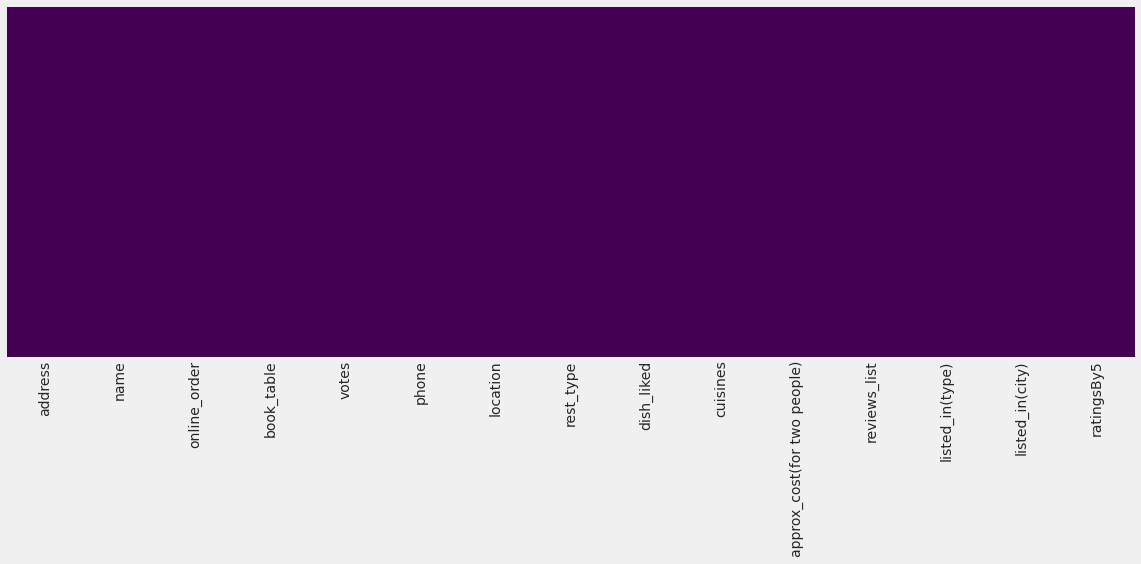

In [89]:
# plot after dealing with null values
plt.figure(figsize=(18,6))
plt.style.use('fivethirtyeight')
sns.heatmap(zomatopd.isnull(),yticklabels=False, cbar=False, cmap= 'viridis');

In [90]:
# doing the same on spark dataframe

from pyspark.sql.functions import isnan,isnull, when, count, col

zomatospark.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in zomatospark.columns]).toPandas()

,address,name,onlineOrder,bookTable,ratingsBy5,votes,phone,location,restType,dishLiked,cuisines,approx_cost(for two people),reviewsList,listedInType,listedInCity
0,0,0,0,0,7775,0,0,21,227,28078,45,346,0,0,0


In [91]:
# votes
zomatospark = zomatospark.withColumn('votes',zomatospark['votes'].cast('integer'))

# approx cost
zomatospark = zomatospark.withColumn('approx_cost(for two people)',F.regexp_replace('approx_cost(for two people)',',','').cast('integer'))
zomatospark = zomatospark.withColumn('approx_cost(for two people)', F.round('approx_cost(for two people)'))

# ratings
zomatospark= zomatospark.withColumn('ratingsBy5',F.trim(F.split(zomatospark['ratingsBy5'],'/')[0]).cast('float'))

In [92]:
zomatospark = zomatospark.fillna({'ratingsBy5':zomatopd['ratingsBy5'].mean()})
zomatospark = zomatospark.withColumn('ratingsBy5', F.round('ratingsBy5',1))

In [93]:
zomatospark = zomatospark.fillna({'approx_cost(for two people)':zomatopd['approx_cost(for two people)'].mean(),\
                                              'votes':zomatopd['votes'].mean(),\
                                              'location':'Unknown',\
                                              'restType':'Unknown','cuisines':'Unknown','reviewsList':'Unknown',\
                                              'listedInType':'Unknown','listedInCity':'Unknown','dishLiked':'Unknown'})

In [94]:
zomatospark = zomatospark.withColumn('restType',F.regexp_replace('restType','NaN','Unknown'))
zomatospark = zomatospark.withColumn('location',F.regexp_replace('location','NaN','Unknown'))
zomatospark = zomatospark.withColumn('cuisines',F.regexp_replace('cuisines','NaN','Unknown'))
zomatospark = zomatospark.withColumn('dishLiked',F.regexp_replace('dishLiked','NaN','Unknown'))

In [95]:
zomatospark.printSchema()

root
 |-- address: string (nullable = true)
 |-- name: string (nullable = true)
 |-- onlineOrder: string (nullable = true)
 |-- bookTable: string (nullable = true)
 |-- ratingsBy5: float (nullable = true)
 |-- votes: integer (nullable = true)
 |-- phone: string (nullable = true)
 |-- location: string (nullable = false)
 |-- restType: string (nullable = false)
 |-- dishLiked: string (nullable = false)
 |-- cuisines: string (nullable = false)
 |-- approx_cost(for two people): integer (nullable = true)
 |-- reviewsList: string (nullable = false)
 |-- listedInType: string (nullable = false)
 |-- listedInCity: string (nullable = false)



In [96]:
zomatospark.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in zomatospark.columns]).toPandas().head()

,address,name,onlineOrder,bookTable,ratingsBy5,votes,phone,location,restType,dishLiked,cuisines,approx_cost(for two people),reviewsList,listedInType,listedInCity
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [97]:
zomatopd = zomatopd.drop_duplicates()
zomatospark = zomatospark.drop_duplicates()

In [98]:
# renaming
zomatopd.columns =['address', 'name', 'onlineOrder', 'bookTable', 'votes', 'phone',
       'location', 'restType', 'dishLiked', 'cuisines',
       'approxCost(2 people)', 'reviewsList', 'listedInType',
       'listedInCity', 'ratingsBy5']

# reordering
zomatopd = zomatopd[['name','address','location','phone','onlineOrder', 'bookTable', 'votes',
       'restType', 'dishLiked', 'cuisines',
       'approxCost(2 people)', 'reviewsList', 'listedInType',
       'listedInCity', 'ratingsBy5']]

In [99]:
# renaming
zomatospark = zomatospark.withColumnRenamed('approx_cost(for two people)','approxCost(2 people)')

# reordering
zomatospark = zomatospark.select(['name','address','location','phone','onlineOrder', 'bookTable', 'votes',
       'restType', 'dishLiked', 'cuisines',
       'approxCost(2 people)', 'reviewsList', 'listedInType',
       'listedInCity', 'ratingsBy5'])

zomatospark = zomatospark.persist()

In [100]:
# descriptive statistics
zomatospark.describe(['location','votes','approxCost(2 people)','ratingsBy5','restType','listedInType','cuisines']).show()

+-------+-----------+-----------------+--------------------+------------------+--------+-------------+--------------------+
|summary|   location|            votes|approxCost(2 people)|        ratingsBy5|restType| listedInType|            cuisines|
+-------+-----------+-----------------+--------------------+------------------+--------+-------------+--------------------+
|  count|      51667|            51667|               51667|             51667|   51667|        51667|               51667|
|   mean|       null|283.8503687072987|   555.4609325101128|3.7003754879771344|    null|         null|                null|
| stddev|       null|804.1670052025419|   437.4373818163472|0.3954810130866859|    null|         null|                null|
|    min|        BTM|                0|                  40|               1.8|  Bakery|       Buffet|     African, Burger|
|    max|Yeshwantpur|            16832|                6000|               4.9| Unknown|Pubs and bars|Vietnamese, Thai,...|
+-------

In [101]:
zomatopd_noOutliers = zomatopd.copy()
zomatospark_noOutliers = zomatospark

In [102]:
zomatospark_noOutliers.agg(F.skewness(zomatospark_noOutliers['votes']).alias("Skewness of Votes"),\
                                      F.skewness(zomatospark_noOutliers['ratingsBy5']).alias("Skewness of Ratings"),\
                                      F.skewness(zomatospark_noOutliers['approxCost(2 people)']).alias("Skewness of Cost")\
                                     ).show()

+-----------------+--------------------+------------------+
|Skewness of Votes| Skewness of Ratings|  Skewness of Cost|
+-----------------+--------------------+------------------+
|7.545034291660263|-0.36558117214664265|2.6109886503268998|
+-----------------+--------------------+------------------+



/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



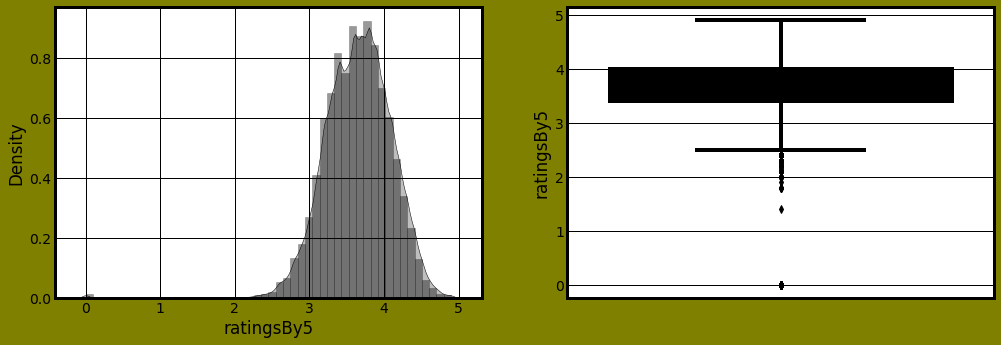

In [103]:
# ratings outliers
fig = plt.figure(figsize=(15,5))
fig.patch.set_facecolor('olive')
plt.style.use('grayscale')
plt.subplot(121)
sns.distplot(zomatopd_noOutliers['ratingsBy5'],kde_kws={"shade": True})
plt.subplot(122)
sns.boxplot(y=zomatopd_noOutliers['ratingsBy5']);

In [104]:
# Outlier handling
IQR = zomatopd_noOutliers['ratingsBy5'].quantile(0.75) - zomatopd_noOutliers['ratingsBy5'].quantile(0.25)

Lower_fence = zomatopd_noOutliers['ratingsBy5'].quantile(0.25) - (IQR * 1.5)
Upper_fence = zomatopd_noOutliers['ratingsBy5'].quantile(0.75) + (IQR * 1.5)

Upper_boundary = zomatopd_noOutliers['ratingsBy5'].mean() + 3* zomatopd_noOutliers['ratingsBy5'].std()
Lower_boundary = zomatopd_noOutliers['ratingsBy5'].mean() - 3* zomatopd_noOutliers['ratingsBy5'].std()

zomatopd_noOutliers['ratingsBy5'] = np.where(zomatopd_noOutliers['ratingsBy5'] < Lower_boundary,zomatopd_noOutliers['ratingsBy5'].median(),zomatopd_noOutliers['ratingsBy5'])

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



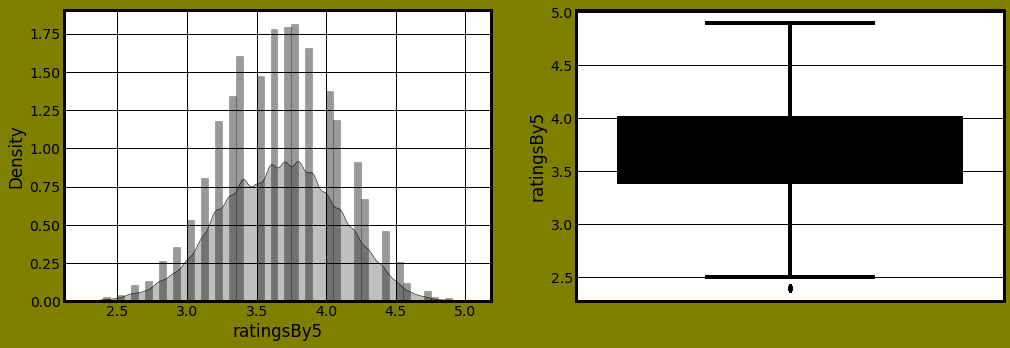

In [105]:
# ratings without outliers
fig = plt.figure(figsize=(15,5))
fig.patch.set_facecolor('olive')
plt.style.use('grayscale')

plt.subplot(121)
sns.distplot(zomatopd_noOutliers['ratingsBy5'],kde_kws={"shade": True})
plt.subplot(122)
sns.boxplot(y=zomatopd_noOutliers['ratingsBy5']);

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



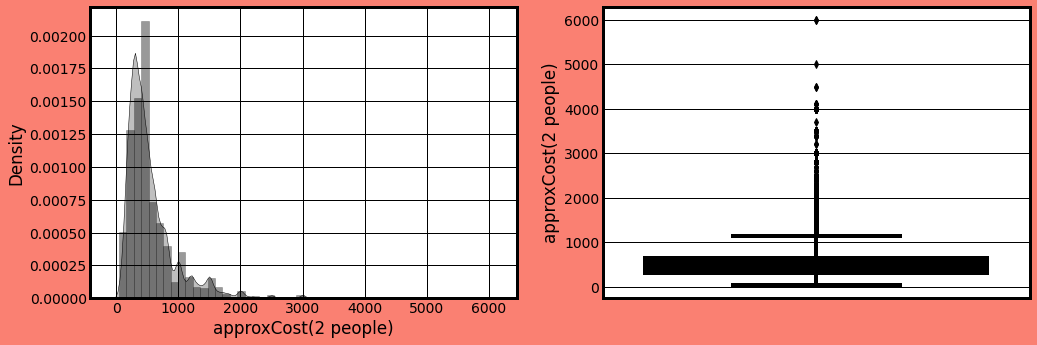

In [106]:
# approx cost with outliers
fig = plt.figure(figsize=(15,5))
fig.patch.set_facecolor('salmon')
plt.style.use('grayscale')
plt.subplot(121)
sns.distplot(zomatopd_noOutliers['approxCost(2 people)'],kde_kws={"shade": True})
plt.subplot(122)
sns.boxplot(y=zomatopd_noOutliers['approxCost(2 people)']);

In [107]:
# handling outliers
IQR = zomatopd_noOutliers['approxCost(2 people)'].quantile(0.75) - zomatopd_noOutliers['approxCost(2 people)'].quantile(0.25)

Lower_fence = zomatopd_noOutliers['approxCost(2 people)'].quantile(0.25) - (IQR * 1.5)
Upper_fence = zomatopd_noOutliers['approxCost(2 people)'].quantile(0.75) + (IQR * 1.5)

zomatopd_noOutliers['approxCost(2 people)'] = np.where(zomatopd_noOutliers['approxCost(2 people)'] > Upper_fence,zomatopd_noOutliers['approxCost(2 people)'].median(),zomatopd_noOutliers['approxCost(2 people)'])

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



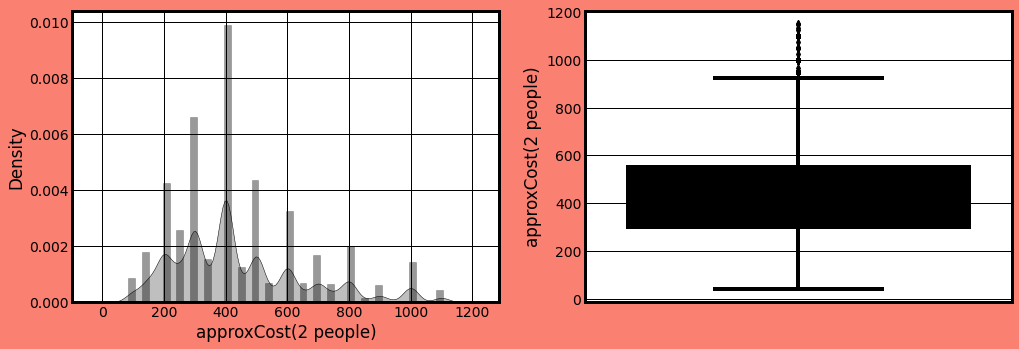

In [108]:
# approx cost without outliers
fig = plt.figure(figsize=(15,5))
fig.patch.set_facecolor('salmon')
plt.style.use('grayscale')
plt.subplot(121)
sns.distplot(zomatopd_noOutliers['approxCost(2 people)'],kde_kws={"shade": True})
plt.subplot(122)
sns.boxplot(y=zomatopd_noOutliers['approxCost(2 people)']);

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



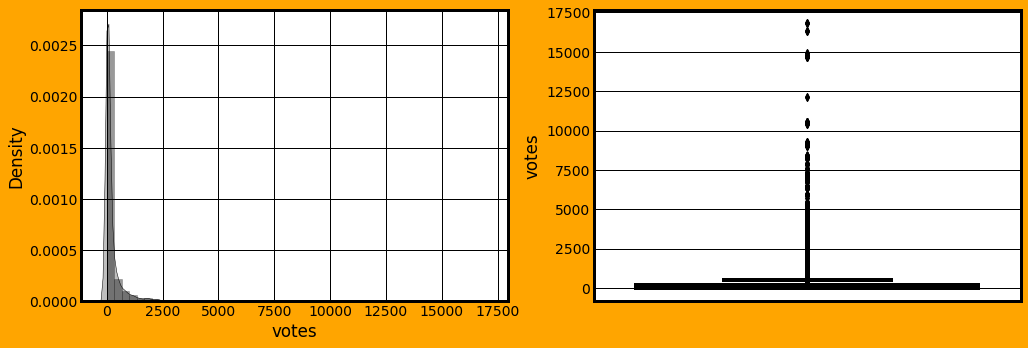

In [109]:
# votes with outliers
fig = plt.figure(figsize=(15,5))
fig.patch.set_facecolor('orange')
plt.style.use('grayscale')
plt.subplot(121)
sns.distplot(zomatopd_noOutliers['votes'],kde_kws={"shade": True})
plt.subplot(122)
sns.boxplot(y=zomatopd_noOutliers['votes']);

In [110]:
# outlier handling
IQR = zomatopd_noOutliers['votes'].quantile(0.75) - zomatopd_noOutliers['votes'].quantile(0.25)

Lower_fence = zomatopd_noOutliers['votes'].quantile(0.25) - (IQR * 3)
Upper_fence = zomatopd_noOutliers['votes'].quantile(0.75) + (IQR * 3)

Upper_boundary = zomatopd_noOutliers['votes'].mean() + 3* zomatopd_noOutliers['votes'].std()
Lower_boundary = zomatopd_noOutliers['votes'].mean() - 3* zomatopd_noOutliers['votes'].std()

zomatopd_noOutliers[zomatopd_noOutliers['votes'] >936.84].shape[0]

zomatopd_noOutliers['votes'] = np.where(zomatopd_noOutliers['votes'] > Upper_fence,zomatopd_noOutliers['votes'].median(),zomatopd_noOutliers['votes'])

3899

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



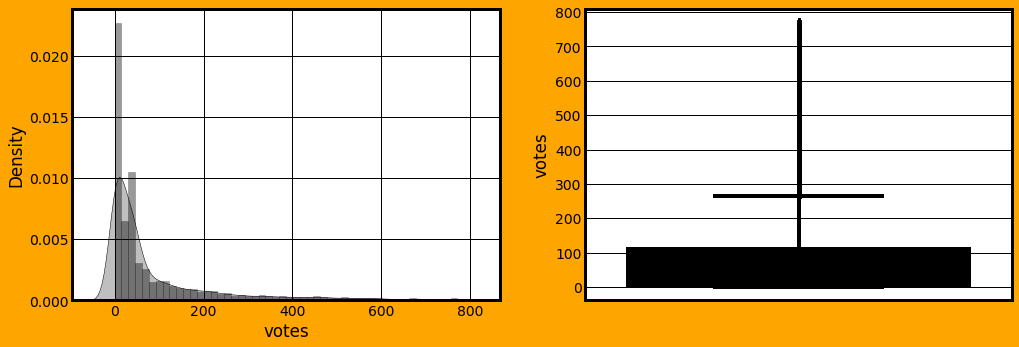

In [111]:
# votes without outliers
fig = plt.figure(figsize=(15,5))
fig.patch.set_facecolor('orange')
plt.style.use('grayscale')
plt.subplot(121)
sns.distplot(zomatopd_noOutliers['votes'],kde_kws={"shade": True})
plt.subplot(122)
sns.boxplot(y=zomatopd_noOutliers['votes']);

In [112]:
zomatospark_noOutliers = zomatospark_noOutliers.withColumn('votes',F.sqrt(F.cbrt(zomatospark_noOutliers['votes'])))
zomatospark_noOutliers = zomatospark_noOutliers.withColumn('approxCost(2 people)',F.cbrt(F.cbrt(F.cbrt(F.cbrt(zomatospark_noOutliers['approxCost(2 people)'])))))
zomatospark_noOutliers.agg(F.skewness(zomatospark_noOutliers['votes']).alias("Skewness of Votes"),\
                                      F.skewness(zomatospark_noOutliers['ratingsBy5']).alias("Skewness of Ratings"),\
                                      F.skewness(zomatospark_noOutliers['approxCost(2 people)']).alias("Skewness of Cost")\
                                     ).show()

+-------------------+--------------------+-------------------+
|  Skewness of Votes| Skewness of Ratings|   Skewness of Cost|
+-------------------+--------------------+-------------------+
|-0.3139478117122944|-0.36558117214664265|0.29374323902988164|
+-------------------+--------------------+-------------------+



In [113]:
zomatospark_noOutliers = zomatospark_noOutliers.withColumn('approxCost(2 people)', F.round('approxCost(2 people)',2))
zomatospark_noOutliers = zomatospark_noOutliers.withColumn('votes', F.round('votes',1))

In [114]:
zomatospark_noOutliers = zomatospark_noOutliers.persist()

In [115]:
# Feature engineering
zomatoML = zomatopd_noOutliers.copy()
zomatoML['onlineOrder'] = zomatoML['onlineOrder'].replace({'Yes':1,'No':0})
zomatoML['bookTable'] = zomatoML['bookTable'].replace({'Yes':1,'No':0})

def Encode(zomato):
    for column in zomato.columns[zomato.columns.isin(['listedInType','listedInCity', 'location'])]:
        zomato[column] = zomato[column].factorize()[0]
    return zomato

zomatoML = Encode(zomatoML)


In [116]:
zomatoML['votes'] = np.sqrt(zomatoML['votes']);
zomatoML['approxCost(2 people)'] =np.sqrt(np.sqrt(np.sqrt(zomatoML['approxCost(2 people)'])))

In [117]:
def Encode(zomato):
    for column in zomato.columns[zomato.columns.isin(['name', 'address', 'restType','dishLiked','cuisines','reviewsList'])]:
        zomato[column] = zomato[column].factorize()[0]
    return zomato

zomatoML = Encode(zomatoML)

In [118]:
zomatoML = zomatoML.drop('phone',axis=1)
zomatoML['votes'] = zomatoML['votes'].apply(lambda x: np.round(x,1))
zomatoML['approxCost(2 people)'] = zomatoML['approxCost(2 people)'].apply(lambda x: np.round(x,1))
zomatoML['location'] = np.sqrt(zomatoML['location'])
zomatoML['dishLiked'] = np.cbrt(np.cbrt(np.sqrt(np.sqrt(zomatoML['dishLiked']))))

<Figure size 1080x576 with 0 Axes>

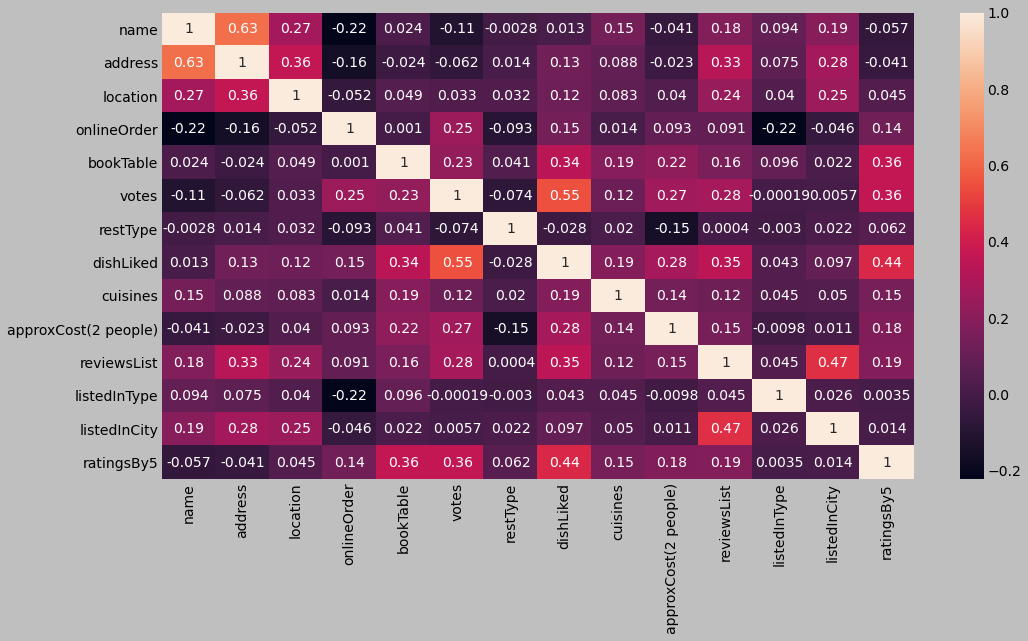

In [119]:
# correlation plot
fig = plt.figure(figsize=(15,8))
fig.patch.set_facecolor('plum')
corr = zomatoML.corr(method='kendall')
plt.figure(figsize=(15,8))
sns.heatmap(corr, annot=True)
zomatoML.columns;

In [120]:
zomatoML.columns.to_flat_index()
z = zomatoML

Index(['name', 'address', 'location', 'onlineOrder', 'bookTable', 'votes',
       'restType', 'dishLiked', 'cuisines', 'approxCost(2 people)',
       'reviewsList', 'listedInType', 'listedInCity', 'ratingsBy5'],
      dtype='object')

In [121]:
df = pd.DataFrame(z) 
  
# saving the dataframe 
df.to_csv('file1.csv') 

odf = spark.createDataFrame(df)

In [122]:
# Exploratory data analysis

# 1. Top 10 Restaurent types in Bangalore

import plotly.graph_objs as go

restTypeData = zomatopd_noOutliers.restType.value_counts().head(10)
colors=['#57167E','#9B3192','#EA5F89','#F7B7A3','#FFF1C9','#E6F69D','#AADEA7','#64C2A6','#2D87BB','#3700FF']
fig=go.Figure(data=[go.Pie(labels=restTypeData.index,values=restTypeData.values,marker=dict(colors=colors))],layout=go.Layout(title='Top 10 Types of Restaurants'))
fig.show()
plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



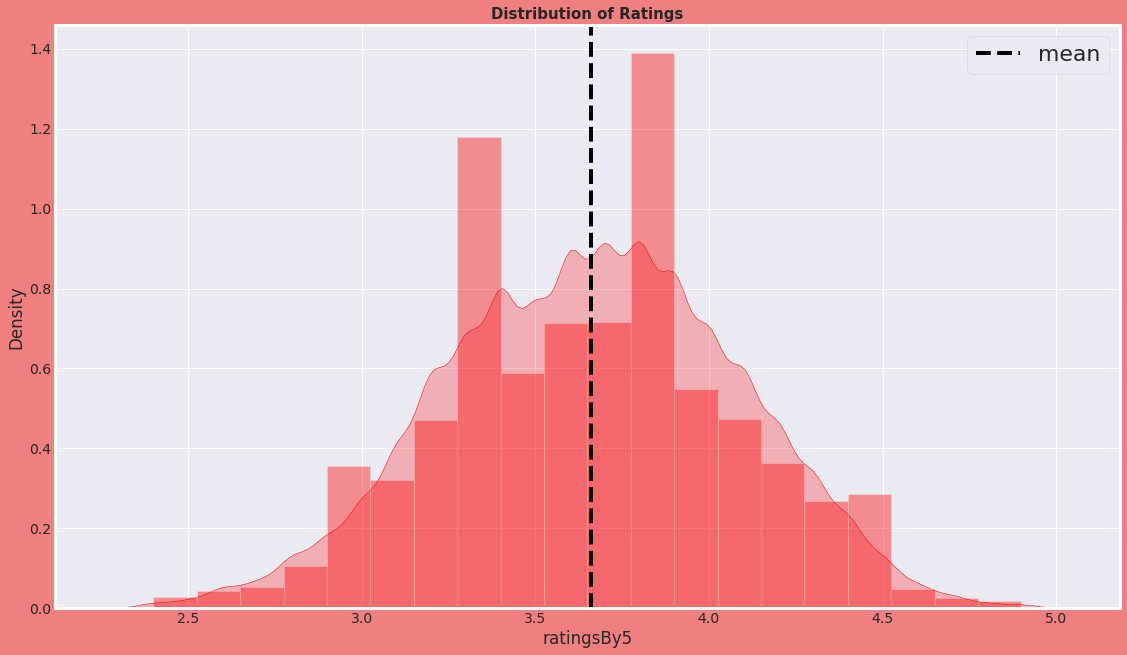

In [123]:
# 2. Ratings distribution in Bangalore

fig = plt.figure(figsize=(17,10))
fig.patch.set_facecolor('lightcoral')

sns.set_style('darkgrid')
sns.distplot(zomatopd_noOutliers['ratingsBy5'], bins = 20,  color= 'red',kde_kws={"shade": True});
plt.axvline(x= zomatopd_noOutliers.ratingsBy5.mean(),ls='--',color='black',linewidth=4,label="mean")
plt.title("Distribution of Ratings",fontweight='bold',fontsize=15);
plt.legend(["mean"],prop={"size":22});

In [124]:
# Feature creation

bins = [0.0,2.0,3.0,4.0,5.0]
labels =["Bad","Average","Good","Excellent"]
zomatopd_noOutliers['RateLabel'] = pd.cut(zomatopd_noOutliers['ratingsBy5'],bins=bins, labels=labels)

def label(ratingsBy5):
  if ratingsBy5 <=2.0:
    return "Bad"
  elif ratingsBy5 >2 and ratingsBy5 <=3:
    return "Average"
  elif ratingsBy5 >3 and ratingsBy5 <=4:
    return "Good"
  else: 
    return "Excellent"

from pyspark.sql.functions import udf

bucket_udf = udf(label, StringType())
zomatospark_noOutliers = zomatospark_noOutliers.withColumn('RateLabel',bucket_udf('ratingsBy5'))

<Figure size 1224x720 with 0 Axes>

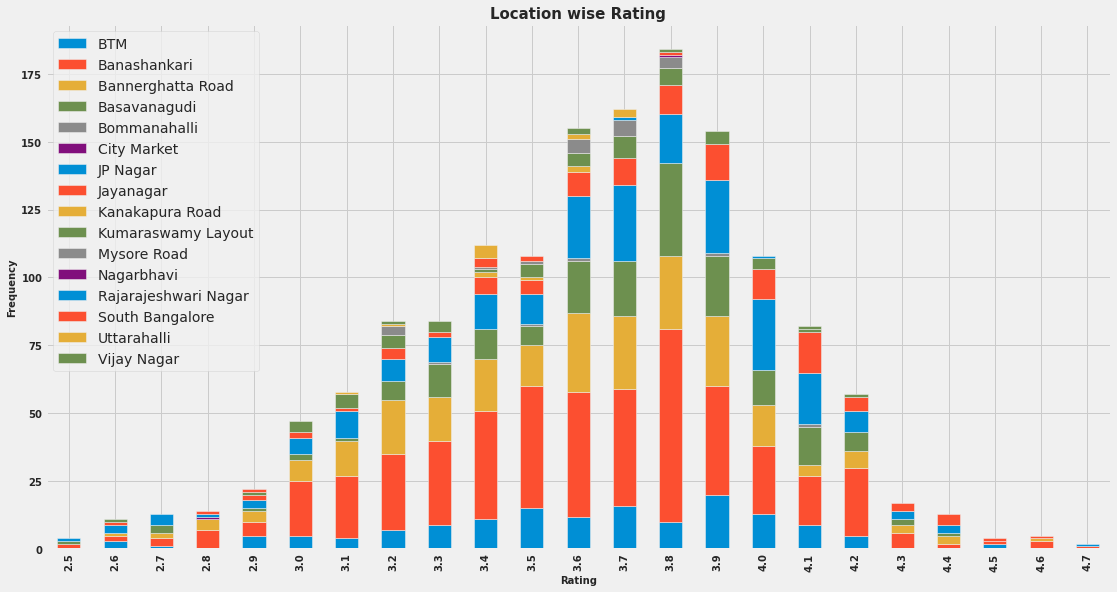

In [125]:
# 3. Location wrt Rating
fig = plt.figure(figsize=(17,10))
fig.patch.set_facecolor('forestgreen')
plt.style.use('fivethirtyeight')

pd.crosstab(zomatopd_noOutliers.ratingsBy5.head(1500),zomatopd_noOutliers.location.head(1500)).plot(kind='bar',stacked=True,figsize= (17,9));
plt.title('Location wise Rating',fontsize=15,fontweight='bold')
plt.ylabel('Frequency',fontsize=10,fontweight='bold')
plt.xlabel('Rating',fontsize=10,fontweight='bold')
plt.xticks(fontsize=10,fontweight='bold')
plt.yticks(fontsize=10,fontweight='bold');
plt.legend(loc = 'upper left');

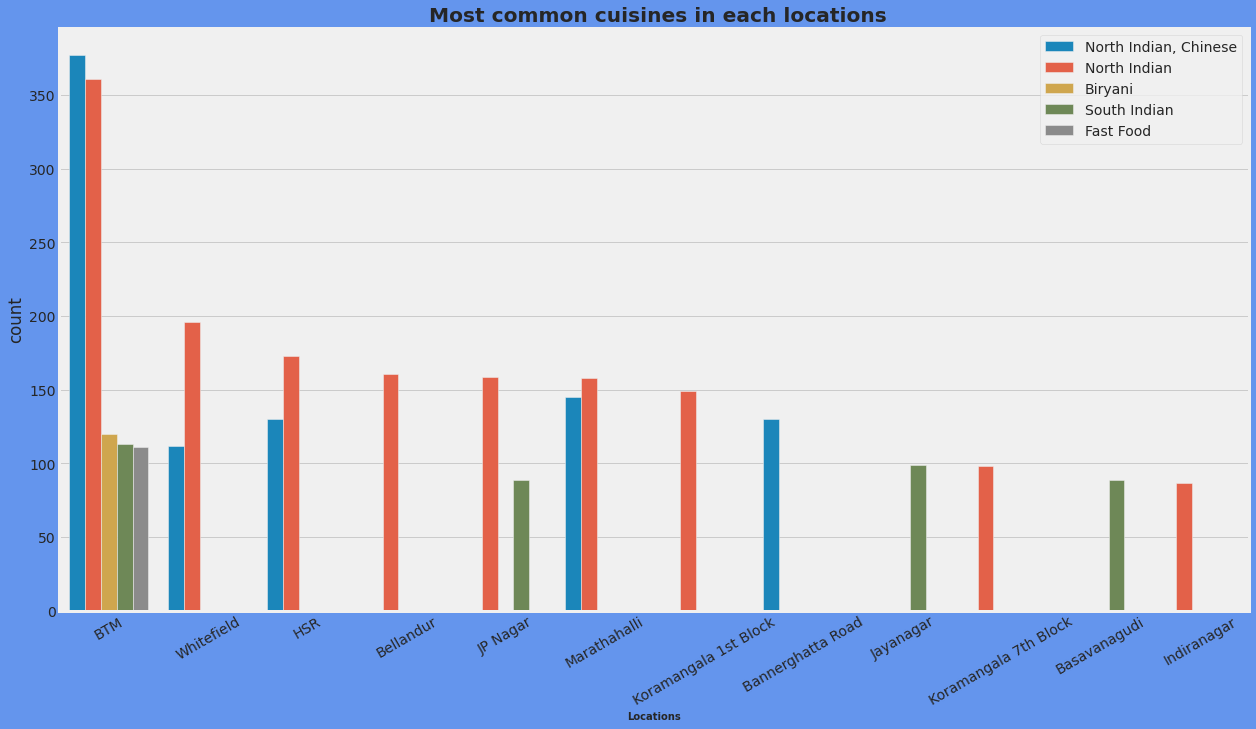

In [126]:
# 4. Common cuisines wrt locations

fig = plt.figure(figsize=(19,10))
fig.patch.set_facecolor('cornflowerblue')
plt.style.use('fivethirtyeight')

top20CuisinesLoc = zomatopd_noOutliers.groupby(['location','cuisines'])['name'].count().sort_values(ascending=False).head(20).reset_index()
top20CuisinesLoc.columns=['location','cuisines','count']
sns.barplot(data=top20CuisinesLoc,x='location',y='count',hue='cuisines')
plt.xticks(rotation=30)
plt.legend(loc='upper right')
plt.title(" Most common cuisines in each locations",fontweight='bold')
plt.xlabel('Locations',fontsize=10,fontweight='bold');

In [127]:
# 5. Finding loc of nearby restaurents

locations=pd.DataFrame({"Name":zomatopd_noOutliers['location'].unique()})
locations['Name']=locations['Name'].apply(lambda x: "Bangalore " + str(x))
lat_lon=[]
geolocator=Nominatim(user_agent="app")
for location in locations['Name']:
    location = geolocator.geocode(location, timeout= 20)
    if location is None:
        lat_lon.append(np.nan)
    else:    
        geo=(location.latitude,location.longitude)
        lat_lon.append(geo)


locations['geo_loc']=lat_lon

locations["Name"]=locations['Name'].apply(lambda x :  x.replace("Bangalore","")[1:])
rest_count= pd.DataFrame(zomatoDataPandas_withoutOutliers['location'].value_counts().reset_index())
rest_count.columns= ['Name', 'count']
rest_count=rest_count.merge(locations, on = "Name", how = "left" ).dropna()


In [128]:
maps = folium.Map(location= [12.97 , 77.59], zoom_start= 12)
folium.Marker(
location= [12.97 , 77.59], popup= 'geographical center of Bangaluru', 
    icon= folium.Icon(color= 'green', icon= 'ok-sign')).add_to(maps)
lat , lon= zip(*np.array(rest_count['geo_loc']));
rest_count['lat']= lat
rest_count['lon']= lon

HeatMap(rest_count[['lat', 'lon', 'count']].values.tolist()).add_to(maps);
maps

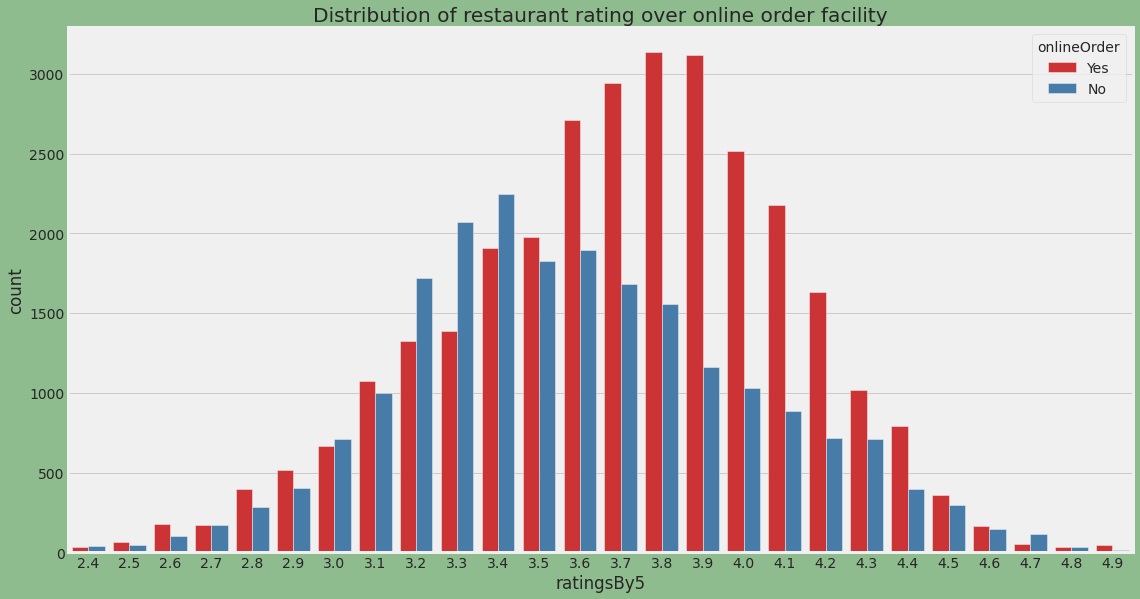

In [129]:
# 6. restaurent rating based on online order facility

fig = plt.figure(figsize=(17,9))
fig.patch.set_facecolor('darkseagreen')
plt.style.use('fivethirtyeight')

sns.countplot(hue = zomatopd_noOutliers["onlineOrder"], palette = "Set1", x = zomatopd_noOutliers["ratingsBy5"])
plt.title("Distribution of restaurant rating over online order facility")
plt.show();

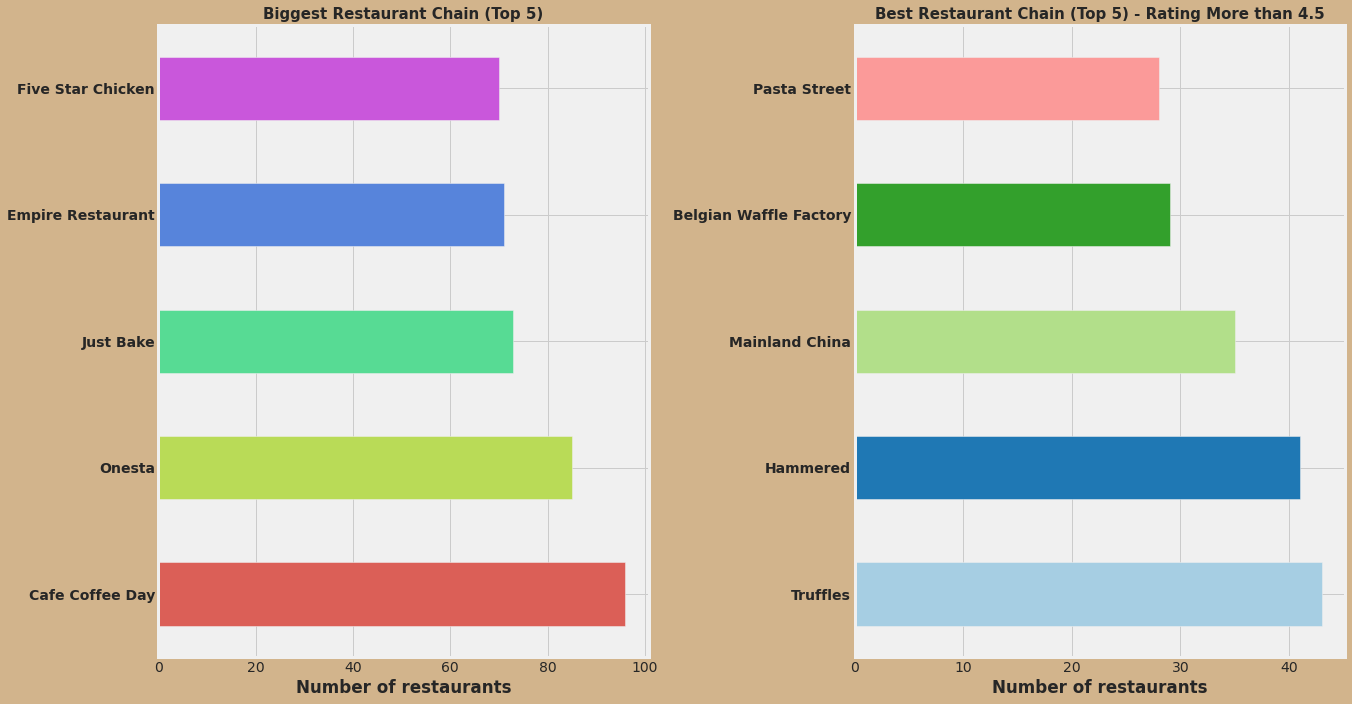

In [130]:
# 7. Biggest and best restaurent chain

fig = plt.figure(figsize=(19,10))
fig.patch.set_facecolor('tan')
plt.style.use('fivethirtyeight')

plt.rcParams['figure.figsize'] = 19,10
plt.subplot(1,2,1)
ax = zomatopd_noOutliers.name.value_counts().head().plot(kind = "barh", color = sns.color_palette("hls", 5))
plt.xlabel("Number of restaurants",fontweight='bold')
plt.yticks(fontweight='bold')
plt.title("Biggest Restaurant Chain (Top 5)",fontweight='bold',fontsize=15);

plt.subplot(1,2,2)
zomatopd_noOutliers[zomatopd_noOutliers['ratingsBy5']>=4.5]['name'].value_counts().nlargest(5).plot(kind = "barh", color = sns.color_palette("Paired"))
plt.xlabel("Number of restaurants",fontweight='bold')
plt.yticks(fontweight='bold')
plt.title("Best Restaurant Chain (Top 5) - Rating More than 4.5",fontweight='bold',fontsize=15);
plt.tight_layout();

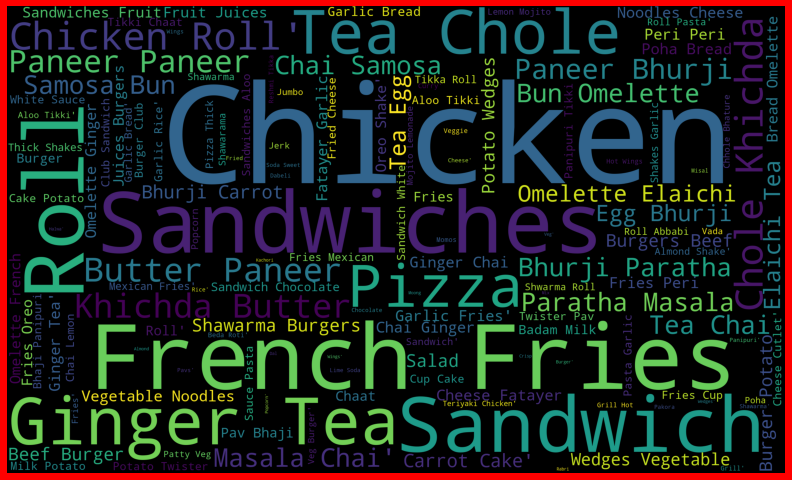

In [131]:
# 8. Wordcloud of dishes liked in fastfood restaurents

fastFood_restaurants = zomatopd_noOutliers[(zomatopd_noOutliers['cuisines']== 'Fast Food') & (zomatopd_noOutliers['dishLiked'] !='Unknown') ]

c1 = ''.join(str(fastFood_restaurants['dishLiked'].values))
from wordcloud import WordCloud
plt.figure(figsize=(15,8),facecolor = 'red')
wordcloud = WordCloud(max_font_size=None, background_color='black', collocations=True,
                      width=2500, height=1500).generate(c1)
plt.imshow(wordcloud)
plt.axis("off");

In [132]:
# 9. Distribution of cost of dishes

bins = [0,200,500,800,1300]
labels = ['cheap','moderate','expensive','extra expensive']
zomatopd_noOutliers['costRange']= pd.cut(zomatopd_noOutliers['approxCost(2 people)'], bins=bins,labels=labels)

def costRange(cost):
  if cost <=200:
    return "cheap"
  elif cost >200 and cost <=500:
    return "moderate"
  elif cost >500 and cost <=800:
    return "expensive"
  else: 
    return "extra expensive"

from pyspark.sql.functions import udf

bucket_udf = udf(costRange, StringType())

zomatospark = zomatospark.withColumn('costRange',bucket_udf('approxCost(2 people)'))
zomatospark_noOutliers = zomatospark.withColumn('costRange',bucket_udf('approxCost(2 people)'))

zomatospark_noOutliers.createOrReplaceTempView("zomatoData")

def doughnutchart(labels,values,title):
    colors=["#F7B7A3","#EA5F89"]
    data=go.Pie(labels=labels,values=values,hole=0.6,pull=0.04,marker=dict(colors=colors))
    layout=go.Layout(title=title)
    fig=go.Figure(data=data,layout=layout)
    iplot(fig)

doughnutchart(zomatopd_noOutliers['costRange'].value_counts().index ,zomatopd_noOutliers['costRange'].value_counts().values,"Distribution of Cost of Dishes")

In [133]:
# Spark ML Models

# Linear Regression on ratings by 5

from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.regression import LinearRegression
from pyspark.ml import classification
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline

# Creating costpipe
vector = VectorAssembler(inputCols=['votes','location','onlineOrder', 'bookTable', 'restType', 'dishLiked', 'approxCost(2 people)'], outputCol = 'features')
LinearReg = LinearRegression(featuresCol= "features", labelCol= "ratingsBy5")

cost_pipe= Pipeline(stages=[vector, LinearReg])

# Splitting pipe into train and test
training,testing = odf.randomSplit([0.66,0.34],seed=50)


In [134]:
# Performing linear regression
regression_model = cost_pipe.fit(training)
lm = regression_model.stages[-1]


In [135]:
# Printing intercepts and coefficients
print('Intercept: ',lm.intercept)
print('Coefficients: ',lm.coefficients)

# Output of Regression
train_result = regression_model.transform(training)
test_result = regression_model.transform(testing)

# Evaluating mean squared error and printing mse for training and testing
Reg_Eval = RegressionEvaluator(predictionCol= "prediction", metricName="mse", labelCol="ratingsBy5")
print('training mse = ',Reg_Eval.evaluate(train_result))
print('testing mse = ', Reg_Eval.evaluate(test_result))

Intercept:  1.7192024414750673
Coefficients:  [0.005159239254646077,-0.0072152753623607666,0.049565579907362864,0.32204263797737853,0.002827185282049364,1.76278133399806,-0.0684923045590608]
training mse =  0.11186597093242968
testing mse =  0.11210459188288555


In [136]:
# Random Forest classifier on online order

from pyspark.ml.classification import RandomForestClassifier
model3 = Pipeline(stages=[VectorAssembler(inputCols=['restType', 'dishLiked', 'location', 'approxCost(2 people)'], outputCol='features'),
                 RandomForestClassifier(labelCol='onlineOrder', featuresCol='features')])

In [137]:
# model fitting and evaluation
from pyspark.ml.evaluation import BinaryClassificationEvaluator, \
    MulticlassClassificationEvaluator, \
    RegressionEvaluator
model3_fitted = model3.fit(training)
evaluator = BinaryClassificationEvaluator(labelCol='onlineOrder')
evaluator.evaluate(model3_fitted.transform(testing))

0.7001694339245581

In [138]:
# Neural network using keras

# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [139]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

print(tf.__version__)

2.3.0


In [140]:
dataset = df.copy()
dataset.tail()

,name,address,location,onlineOrder,bookTable,votes,restType,dishLiked,cuisines,approxCost(2 people),reviewsList,listedInType,listedInCity,ratingsBy5
51712,8727,11402,5.477226,0,0,5.2,17,1.051030,256,2.1,22358,6,29,3.6
51713,8732,11425,5.477226,0,0,0.0,17,1.051030,255,2.2,75,6,29,3.8
51714,8791,11399,5.477226,0,0,0.0,17,1.051030,255,2.1,75,6,29,4.1
51715,8787,11488,8.000000,0,1,15.4,17,1.268752,255,2.1,22464,6,29,4.3
51716,8788,4410,8.000000,0,0,3.6,36,1.051030,612,2.1,22465,6,29,3.4


In [141]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

In [142]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('approxCost(2 people)')
test_labels = test_features.pop('approxCost(2 people)')

In [143]:
normalizer = preprocessing.Normalization()
normalizer.adapt(np.array(train_features))

In [144]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [145]:
cd = pd.read_csv('GfG.csv')

In [146]:
arr = cd.to_numpy()

In [147]:
training = arr[1:35000,1:9]
train_test = arr[1:35000,10]

In [148]:
from keras import models, layers

In [149]:
model = models.Sequential()
model.add(layers.Dense(8, activation='relu', input_shape=[training.shape[1]]))
model.add(layers.Dense(8, activation='relu'))

# output layer
model.add(layers.Dense(1))

In [150]:
model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
history = model.fit(training, train_test, validation_split=0.2, epochs=20)

Epoch 1/20
875/875 [==============================] - 1s 1ms/step - loss: 8867.2705 - mae: 19.0122 - val_loss: 2.1385 - val_mae: 1.4548
Epoch 2/20
875/875 [==============================] - 1s 1ms/step - loss: 1.2288 - mae: 1.0180 - val_loss: 0.3742 - val_mae: 0.5954
Epoch 3/20
875/875 [==============================] - 1s 1ms/step - loss: 0.0999 - mae: 0.2496 - val_loss: 0.0197 - val_mae: 0.1111
Epoch 4/20
875/875 [==============================] - 1s 1ms/step - loss: 0.0199 - mae: 0.1109 - val_loss: 0.0197 - val_mae: 0.1113
Epoch 5/20
875/875 [==============================] - 1s 1ms/step - loss: 0.0199 - mae: 0.1109 - val_loss: 0.0197 - val_mae: 0.1113
Epoch 6/20
875/875 [==============================] - 1s 1ms/step - loss: 0.0199 - mae: 0.1108 - val_loss: 0.0197 - val_mae: 0.1109
Epoch 7/20
875/875 [==============================] - 1s 1ms/step - loss: 0.0199 - mae: 0.1106 - val_loss: 0.0198 - val_mae: 0.1120
Epoch 8/20
875/875 [==============================] - 1s 1ms/step - loss

In [151]:
X_test_scaled = arr[35000:53000,1:9]
y_test = arr[35000:53000,10]

In [152]:
model.evaluate(X_test_scaled, y_test)

522/522 [==============================] - 0s 800us/step - loss: 0.0197 - mae: 0.1085


[0.019718019291758537, 0.10845249891281128]

In [ ]:
########### PART 4 RECOMMENDATION SYSTEM #############

In [ ]:
case = zomatoDataPyspark.select("*").toPandas()

loc_list = zomatoDataPandas['location'].unique()


cuis = zomatoDataPandas['cuisines'].unique()

rea_type = zomatoDataPandas['rest_type'].unique()

rea_type

u = input()



"""lst = [] 

loc_list = zomatoDataPandas['location'].unique()
onlinestatus = [1,0,'Yes','No','yes','no']
cuis = zomatoDataPandas['cuisines'].unique()
rea_type = zomatoDataPandas['rest_type'].unique()
fg = [loc_list,cuis,rea_type,onlinestatus]
# number of elemetns as input 
x = ['whats ur location preference','whats your cuisine preference','what restaurant type are you looking for','Do u need Online delivery']
# iterating till the range 
for i in range(0, 4): 
    x[i]
    ele = input() 
    p = 3;
    while ((ele not in fg[i]) and (p != 0)):
      print('Enter a valid input')
      ele = input()
    lst.append(ele)      
print(lst) """



def choice(lst):
  global frame
  if (lst[1] in fg[1]):
    frame = zomatoDataPandas[zomatoDataPandas['location']==lst[1]]
  if (lst[2] in fg[2]):
    frame = zomatoDataPandas[zomatoDataPandas['cuisines']==lst[1]]
  if (lst[2] in fg[2]):
    frame = zomatoDataPandas[zomatoDataPandas['res_type']==lst[1]]
  if (lst[2] in fg[2]):
    frame = zomatoDataPandas[zomatoDataPandas['onlineOrder']==lst[1]]
  print(frame.head())
  frame_one = frame.sort_values('rate',ascending=False)
  print(frame_one.head())


choice(lst)

lst = [] 

loc_list = zomatoDataPandas['location'].unique()
onlinestatus = [1,0,'Yes','No','yes','no']
cuis = zomatoDataPandas['cuisines'].unique()
rea_type = zomatoDataPandas['rest_type'].unique()
fg = [loc_list,cuis,rea_type,onlinestatus]
# number of elemetns as input 
x = ['whats ur location preference','whats your cuisine preference','what restaurant type are you looking for','Do u need Online delivery']
# iterating till the range 
for i in range(0, 4): 
    x[i]
    ele = input() 
    if (ele not in fg[i]):
      print('invalid input') 
      print('pls provide a valid input')
      ele = input()   
    if (ele not in fg[i]):
      print('invalid input')
      print('pls provide a valid input')
      ele = input()
    if (ele not in fg[i]):
      print('invalid input')
      print('pls provide a valid input')
      ele = input()
      print('Choose from the following')
      print(fg[i])
    lst.append(ele)      
print(lst) 

cuis = zomatoDataPandas['cuisines'].unique()

cuis = zomatoDataPandas['cuisines'].unique()

